In [390]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_rows', 200)

In [391]:
#Loading the datasets
ctrain = pd.read_csv('Cleaned_train.csv')
test = pd.read_csv('test.csv')
cweather = pd.read_csv('Cleaned_weather.csv')
cspray = pd.read_csv('Cleaned_spray.csv')

In [392]:
#Dropping NumMosquitos since it is not present in test data
ctrain = ctrain.drop(columns='NumMosquitos')

In [393]:
#Convert to datetime object
cweather['Date'] = pd.to_datetime(cweather['Date'])
ctrain['Date'] = pd.to_datetime(ctrain['Date'])

In [394]:
#Function to access certain weeks in a specific year

def year_week(row):
    week = row['Week']
    year = row['Year']
    row['YearWeek'] = f'{year}{week}'
    row['YearWeek'] = int(row['YearWeek'])
    return row

In [395]:
#Apply the function year_week
ctrain = ctrain.apply(year_week, axis=1)
cweather = cweather.apply(year_week, axis=1)

RELATIVE HUMIDITY

In [396]:
#To convert Fahrenheit to Celcius

def fc(x):
    c = ((x - 32) * 5.0)/9.0
    return float(c)

In [397]:
#Apply the function fc 

cweather['TavgC'] = cweather['Tavg'].apply(fc)
cweather['TminC'] = cweather['Tmin'].apply(fc)
cweather['TmaxC'] = cweather['Tmax'].apply(fc)
cweather['DewPointC'] = cweather['DewPoint'].apply(fc)

In [398]:
#Function to calculate Relative Humidity

def rhm(row):
    row['rhm'] = round(100*(math.exp((17.625*row['DewPointC'])/(243.04+row['DewPointC'])) \
                          / math.exp((17.625*row['TavgC'])/(243.04+row['TavgC']))))
    return row

In [399]:
#Apply function rhm  
cweather = cweather.apply(rhm, axis=1)

In [400]:
# The average humidity in Chicago could be a factor in the spread of the West Nile Virus
cweather['rhm'].mean()

62.21399456521739

In [401]:
# Dropping as these are no longer needed
cweather = cweather.drop(columns=['TavgC', 'TminC', 'TmaxC', 'DewPointC'])

In [402]:
cweather.sort_values(by = 'rhm', ascending=False).head()

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,AvgSpeed,n_codesum,Rain,Mist,Year,Month,Week,DayOfWeek,YearWeek,rhm
1287,2013-10-31,64.5,46.5,55.5,9.5,56.0,57.0,9.5,0.0,623.0,...,11.45,2.0,1.0,1.0,2013,10,44,3,201344,102
1454,2014-10-14,66.0,53.0,60.0,7.0,58.0,59.0,5.0,0.0,603.0,...,9.40,3.0,1.0,1.0,2014,10,42,1,201442,93
319,2008-09-13,76.0,68.5,72.5,7.5,70.0,71.0,0.0,7.5,529.0,...,9.40,2.0,1.0,1.0,2008,9,37,5,200837,92
1286,2013-10-30,63.5,45.0,54.5,8.5,52.0,53.0,10.5,0.0,622.0,...,6.85,3.0,1.0,1.0,2013,10,44,2,201344,91
763,2011-05-28,63.0,51.5,57.5,-5.5,55.0,56.0,7.5,0.0,421.0,...,6.25,3.0,1.0,1.0,2011,5,21,5,201121,91


WEEKLY AVERAGE PRECIPITATION

In [403]:
# Set up a temp df for calculation of cumulative weekly precipitation
temp_df = cweather.groupby('YearWeek').sum()

In [404]:
#Function to calcuate weekly precipitation

def WAP(row):
    YearWeek = row['YearWeek']
    row['WeekPrecipTotal'] = temp_df.loc[YearWeek]['PrecipTotal']
    return row

In [405]:
#Apply function WAP
cweather = cweather.apply(WAP, axis=1)

WEEKLY AVERAGE TEMPERATURE

In [406]:
#Function to calculate weekly average temperature

def WAT(row):
    YearWeek = row['YearWeek']
    temp_sum = temp_df.loc[YearWeek]['Tavg']
    n_days = cweather[cweather['YearWeek'] == YearWeek].shape[0]
    row['WeekAvgTemp'] = temp_sum / n_days
    return row

In [407]:
#Apply functin WAT
cweather = cweather.apply(WAT, axis=1)

TEMPORAL FEATURES:  
                  Seeing that some of the variables have a lagging effect on the growth of the mosquito population, we create lagged variables for the weather features so that the model can account for how the weather conditions in the previous month affect the incidences of the West Nile Virus today.

AVERAGE TEMPERATURE - PREVIOUS MONTH

In [408]:
#Funtction to incorporate the lagged temperature and if no previous data exists replace with mean value 

def templag(row):       
    YearWeek = row['YearWeek'] 
    for i in range(4):  
        try:
            row[f'templag{i+1}'] = cweather[cweather['YearWeek'] == (YearWeek - (i+1))]['WeekAvgTemp'].unique()[0]
        except IndexError:
            row[f'templag{i+1}'] = cweather['WeekAvgTemp'].mean() 
    return row

In [409]:
#Apply function templag
cweather = cweather.apply(templag, axis=1)

In [410]:
#Check the temperature lagged variables are correct
cweather.groupby(by='YearWeek').mean()[['WeekAvgTemp', 'templag1', 'templag2', 'templag3', 'templag4']].tail(5)

,WeekAvgTemp,templag1,templag2,templag3,templag4
YearWeek,,,,,
201440,57.142857,65.285714,62.142857,60.071429,74.428571
201441,53.714286,57.142857,65.285714,62.142857,60.071429
201442,54.000000,53.714286,57.142857,65.285714,62.142857
201443,54.642857,54.000000,53.714286,57.142857,65.285714
201444,50.200000,54.642857,54.000000,53.714286,57.142857


CUMMULATIVE WEEKLY PRECIPITATION - PREVIOUS MONTH

In [411]:
#Funtction to incorportae the lagged precipitation and if no previous data exists replace with mean value 

def preciplag(row):
    YearWeek = row['YearWeek']
    for i in range(4):
        try:
            row[f'preciplag{i+1}'] = cweather[cweather['YearWeek'] == (YearWeek - (i+1))]['WeekPrecipTotal'].unique()[0]
        except IndexError:
            row[f'preciplag{i+1}'] = cweather['WeekPrecipTotal'].mean()
    return row

In [412]:
#Apply  function preciplag
cweather = cweather.apply(preciplag, axis=1)

RELATIVE HUMIDITY - PREVIOUS MONTH

In [413]:
# Creating a funtction to incorportae the lagged precipitation  and if no previous data exists replace with mean value 

def rhmlag(row):
    YearWeek = row['YearWeek']
    for i in range(4):
        try:
            row[f'rhmlag{i+1}'] = cweather[cweather['YearWeek'] == (YearWeek - (i+1))]['rhm'].unique()[0]
        except IndexError:
            row[f'rhmlag{i+1}'] = cweather['rhm'].mean()
    return row

In [414]:
#Apply function rhmlag
cweather = cweather.apply(rhmlag, axis=1)

TRAPS

In [415]:
#Encoding all traps to compare with target variable - One Hot Encoding
ctrain = pd.get_dummies(ctrain, columns=['Trap'])

SPECIES

In [416]:
# WnvPresent based on species
ctrain[['Species', 'WnvPresent']].groupby('Species').sum()

,WnvPresent
Species,
CULEX ERRATICUS,0
CULEX PIPIENS,240
CULEX PIPIENS/RESTUANS,262
CULEX RESTUANS,49
CULEX SALINARIUS,0
CULEX TARSALIS,0
CULEX TERRITANS,0


In [417]:
ctrain['Species'] = ctrain['Species'].map({'CULEX PIPIENS/RESTUANS': 2, 'CULEX PIPIENS': 2, 'CULEX RESTUANS': 1}) \
                                   .fillna(0)

In [418]:
# Checking species value count
ctrain['Species'].value_counts()

2.0    7451
1.0    2740
0.0     315
Name: Species, dtype: int64

FEATURE SELECTION

POLYNOMIAL FEATURE ENGINEERING

In [419]:
merged_df = pd.merge(cweather, ctrain, on=['Date', 'Year', 'Week', 'Month', 'YearWeek', 'DayOfWeek'])

In [420]:
X = merged_df[[col for col in merged_df.columns if 'WnvPresent' not in col]]._get_numeric_data()
y = ctrain['WnvPresent']

In [421]:
#Generate the full polynomial feature table
poly = PolynomialFeatures(include_bias=False, degree=2)
X_poly = poly.fit_transform(X)
X_poly.shape

(10506, 16470)

In [422]:
#Add appropriate feature names to all polynomial features
X_poly = pd.DataFrame(X_poly,columns=poly.get_feature_names(X.columns))

In [423]:
#Generate list of poly feature correlations
X_poly_corrs = X_poly.corrwith(y)

In [427]:
#Show features most highly correlated (positively) with target
X_poly_corrs.sort_values(ascending=False).head(50)

Sunrise WeekAvgTemp        0.150030
Sunrise templag2           0.147419
Sunrise templag3           0.147091
Sunrise templag1           0.144225
WetBulb Sunrise            0.143433
DewPoint Sunrise           0.142001
DewPoint Week              0.141467
Tmin Sunrise               0.140002
Week WeekAvgTemp           0.139110
WetBulb Week               0.138456
Week templag2              0.138359
DewPoint Month             0.137620
Tmin Week                  0.137041
Week templag3              0.136736
Month templag3             0.134532
WetBulb Month              0.133504
templag2 templag3          0.133076
Tavg Sunrise               0.132760
Tmin Month                 0.132468
Week templag1              0.132166
Month templag2             0.131850
templag3 Species           0.130654
Month WeekAvgTemp          0.130124
Week Species               0.129371
Tavg Week                  0.129274
DewPoint Species           0.128574
Sunrise Sunset             0.128111
Month Species              0

In [428]:
#Selecting 3 features to avoid multicollinearity issues
merged_df['Sunrise_WeekAvgTemp'] = merged_df['Sunrise'] * merged_df['WeekAvgTemp']
merged_df['DewPoint_Sunrise'] = merged_df['DewPoint'] * merged_df['Sunrise']
merged_df['Depart_WeekPrecipTotal'] = merged_df['Depart'] * merged_df['WeekPrecipTotal']

In [429]:
cm = abs(merged_df.corr()['WnvPresent']).sort_values(ascending=False)

In [430]:
#Drop columns with less than 2% correlation to WnvPresent
cols_to_drop = cm[cm < 0.02].index
cols_to_drop

Index(['Trap_T013', 'Trap_T230', 'Trap_T014', 'Trap_T148', 'Trap_T016',
       'Trap_T043', 'Trap_T018', 'Trap_T212', 'Trap_T145', 'Trap_T074',
       ...
       'Trap_T162', 'Trap_T156', 'Trap_T039', 'Trap_T142', 'PrecipTotal',
       'Trap_T227', 'Trap_T033', 'Trap_T066', 'Trap_T226', 'ResultDir'],
      dtype='object', length=131)

In [431]:
merged_df = merged_df.drop(columns=cols_to_drop)
merged_df.shape

(10506, 57)

<AxesSubplot:>

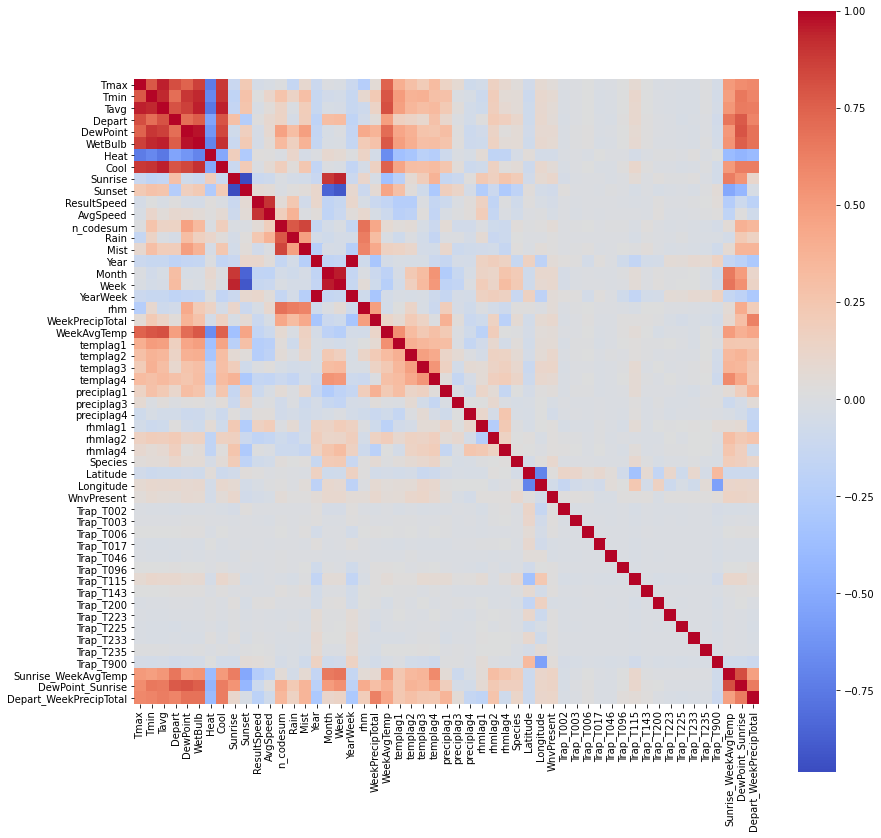

In [432]:
plt.figure(figsize=(14, 14))
sns.heatmap(merged_df.corr(), cmap='coolwarm', square=True)

SELECTING TOP FEATURES

In [433]:
cm = abs(merged_df.corr()['WnvPresent']).sort_values(ascending=False)
cm = cm.drop('WnvPresent')
cols_to_keep = cm.head(40)
cols_to_keep

Sunrise_WeekAvgTemp       0.150030
DewPoint_Sunrise          0.142001
Depart_WeekPrecipTotal    0.120779
templag3                  0.120568
templag2                  0.106181
Sunrise                   0.105227
Week                      0.104171
Species                   0.103477
Month                     0.100143
WeekPrecipTotal           0.098721
templag4                  0.087055
DewPoint                  0.085883
WetBulb                   0.080468
Tmin                      0.074048
Sunset                    0.068451
templag1                  0.065369
Tavg                      0.064256
Longitude                 0.060345
Cool                      0.058101
WeekAvgTemp               0.054949
preciplag4                0.054830
Heat                      0.054740
YearWeek                  0.053012
Depart                    0.052586
rhm                       0.052098
n_codesum                 0.051083
Year                      0.050865
Tmax                      0.048244
ResultSpeed         

In [434]:
ftrain = merged_df[cols_to_keep.keys()]

In [435]:
ftrain.shape

(10506, 40)

In [451]:
#Check for null values in ftrain
ftrain.isnull().sum()[ftrain.isnull().sum()>0]

Series([], dtype: int64)

In [437]:
ftrain.to_csv('Final_train.csv', index=False)

TEST DATA PREPARATION

In [438]:
test = pd.get_dummies(test, columns=['Trap'])

In [439]:
test['Date'] = pd.to_datetime(test['Date'])

In [440]:
test['Species'] = test['Species'].map({'CULEX PIPIENS/RESTUANS': 2, 'CULEX PIPIENS': 2, 'CULEX RESTUANS': 1}).fillna(0)

In [441]:
merged_test = pd.merge(cweather, test)

In [442]:
merged_test.columns

Index(['Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat',
       'Cool', 'Sunrise',
       ...
       'Trap_T231', 'Trap_T232', 'Trap_T233', 'Trap_T234', 'Trap_T235',
       'Trap_T236', 'Trap_T237', 'Trap_T238', 'Trap_T900', 'Trap_T903'],
      dtype='object', length=198)

In [445]:
merged_test['Sunrise_WeekAvgTemp'] = merged_test['Sunrise'] * merged_test['WeekAvgTemp']
merged_test['DewPoint_Sunrise'] = merged_test['DewPoint'] * merged_test['Sunrise']
merged_test['Depart_WeekPrecipTotal'] = merged_df['Depart'] * merged_df['WeekPrecipTotal']

In [446]:
ftest = merged_test[cols_to_keep.keys()]

In [447]:
#Check for missing columns
[col for col in ftest if col not in ftrain], [col for col in ftrain if col not in ftest]

([], [])

In [448]:
ftest.shape

(116293, 40)

In [450]:
#Check for null values in ftest
ftest.isnull().sum()[ftest.isnull().sum() > 0]

Depart_WeekPrecipTotal    105787
dtype: int64

In [452]:
ftest.to_csv('Final_test.csv', index=False)